In [11]:
pip install opencv-python


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [12]:
pip install tensorflow[and-cuda]

  Using cached nvidia_cublas_cu12-12.2.5.6-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.2.142-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cuda_nvcc_cu12-12.2.140-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.2.140-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.2.140-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cudnn_cu12-8.9.4.25-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cufft_cu12-11.0.8.103-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.3.141-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.5.2.141-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.2.141-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.16.5-py3-none-manyl

In [13]:
pip install tensorflow==2.15.0

  Using cached tensorflow-2.15.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.4 kB)
  Using cached ml_dtypes-0.2.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
  Using cached tensorboard-2.15.2-py3-none-any.whl.metadata (1.7 kB)
  Using cached keras-2.15.0-py3-none-any.whl.metadata (2.4 kB)
Using cached tensorflow-2.15.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (475.2 MB)
Using cached keras-2.15.0-py3-none-any.whl (1.7 MB)
Using cached ml_dtypes-0.2.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.0 MB)
Using cached tensorboard-2.15.2-py3-none-any.whl (5.5 MB)
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.3.2
    Uninstalling ml-dtypes-0.3.2:
      Successfully uninstalled ml-dtypes-0.3.2
  Attempting uninstall: keras
    Found existing installation: keras 3.3.3
    Uninstalling keras-3.3.3:
      Successfully uninstalled keras-3.3.3
  Attempting uninstall: tensorb

In [14]:
pip install scikit-learn


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [15]:
pip install matplotlib


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [16]:
pip install keras-tuner


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [17]:
#Imports
import math
import os
import json
import cv2
import numpy as np
import keras
print(keras.__version__)
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, Input, Model
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import tensorflow as tf
print(tf.__version__)
from collections import Counter
import random
from pathlib import Path
from tensorflow.keras.callbacks import EarlyStopping
from keras_tuner import Hyperband
from tensorflow.keras.utils import Sequence



2.15.0
2.15.0


In [18]:
def build_model(hp):
    # Load InceptionV3 model without the top layers
    base_model = InceptionV3(weights='imagenet', include_top=False, pooling='avg')
    base_model.trainable = False

    input_tensor = Input(shape=(frame_count, height, width, 3))
    processed_frames = layers.TimeDistributed(base_model)(input_tensor)

    x = layers.GRU(frame_count, return_sequences=True)(processed_frames)
    x = layers.Flatten()(x)

    x = layers.Dense(hp.Int('dense_1_units', min_value=512, max_value=2080, step=512))(x)
    hp_alpha1 = hp.Float('leaky_relu_alpha1', min_value=0.01, max_value=0.3, step=0.01)
    x = layers.LeakyReLU(alpha=hp_alpha1)(x)

    x = layers.Dense(hp.Int('dense_2_units', min_value=512, max_value=2080, step=512))(x)  
    x = layers.ReLU()(x)
    x = layers.BatchNormalization()(x)

    x = layers.Dense(hp.Int('dense_3_units', min_value=256, max_value=900, step=256))(x)
    hp_alpha2 = hp.Float('leaky_relu_alpha2', min_value=0.01, max_value=0.3, step=0.01)
    x = layers.LeakyReLU(alpha=hp_alpha2)(x)

    x = layers.Dense(hp.Int('dense_4_units', min_value=128, max_value=600, step=128))(x)
    x = layers.ReLU()(x)
    
    outputs = layers.Dense(len(classes), activation='softmax')(x)

    model = models.Model(inputs=input_tensor, outputs=outputs)
    
    hp_learning_rate = hp.Float('adam', min_value=1e-5, max_value=1e-2, sampling='log')
    optimizer = tf.keras.optimizers.Adam(learning_rate=hp_learning_rate)

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

def find_prediction(predictions):
    print(f"predictions: {predictions}")
    print(f"len(predictions): {len(predictions)}")
    # Ensure the list is not empty to avoid ValueError on max()
    final_prediction_index = -1
    final_prediction_tracker = []

    final_predictions = []

    for prediction in predictions.tolist():
        max_value = max(prediction)       # Find the maximum value
        print(f"max_value: {max_value}")
        max_index = prediction.index(max_value)
        print(f"max_index: {max_index}")
        # Return the index of the first occurrence of the maximum value
        final_prediction_tracker.append(max_index)

    for i in range(len(predictions.tolist())):
        final_prediction = [0] * len(prediction)
        final_prediction[final_prediction_tracker[i]] = 1
        final_predictions.append(final_prediction)
    return final_predictions

class VideoGenerator(Sequence):
    def __init__(self, input_dir, batch_size, frame_count, height, width, num_classes, shuffle=True):
        self.input_dir = input_dir
        self.batch_size = batch_size
        self.frame_count = frame_count
        self.height = height
        self.width = width
        self.num_classes = num_classes
        self.shuffle = shuffle
        
        # Initialize lists to hold paths and labels
        self.video_paths = []
        self.labels = []

        # Create a mapping of classes to integer labels
        self.class_to_label = {class_name: idx for idx, class_name in enumerate(sorted(os.listdir(input_dir))) if class_name[0] != '.'}
        
        # Collect all video paths and their associated labels
        for class_name, label in self.class_to_label.items():
            class_path = os.path.join(input_dir, class_name)
            if os.path.isdir(class_path):
                for video_file in os.listdir(class_path):
                    self.video_paths.append(os.path.join(class_path, video_file))
                    self.labels.append(label)

        # Convert labels to categorical (one-hot encoding)
        self.labels = np.array(self.labels)
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.video_paths) / self.batch_size))

    def __getitem__(self, index):
        # Generate indices of the batch
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]

        # Initialize the batch arrays
        batch_videos = np.empty((len(batch_indices), self.frame_count, self.height, self.width, 3))
        batch_labels = np.empty((len(batch_indices), self.num_classes))

        # Process each video file in the batch
        for i, video_idx in enumerate(batch_indices):
            video_path = self.video_paths[video_idx]
            label = self.labels[video_idx]

            # Load the frames from the video file
            frames = self._load_video_frames(video_path)

            # Assign to the batch
            batch_videos[i] = frames
            batch_labels[i] = np.eye(self.num_classes)[label-1]

        return batch_videos, batch_labels

    def on_epoch_end(self):
        """Shuffle the data after each epoch if required."""
        self.indices = np.arange(len(self.video_paths))
        if self.shuffle:
            np.random.shuffle(self.indices)

    def _load_video_frames(self, video_path):
        """Load the frames from a video file up to a specified number of frames."""
        cap = cv2.VideoCapture(video_path)
        frames = []

        while len(frames) < self.frame_count:
            ret, frame = cap.read()
            if not ret:
                break
            frames.append(frame)
        cap.release()

        # Ensure we return exactly `frame_count` frames by either padding or trimming
        while len(frames) < self.frame_count:
            frames.append(np.zeros((self.height, self.width, 3)))

        frames = np.array(frames[:self.frame_count])

        return frames

Epoch 1/10
8/8 [==============================] - 21s 2s/step - loss: 29.3672 - accuracy: 0.2821 - val_loss: 55.5279 - val_accuracy: 0.3333
Epoch 2/10
8/8 [==============================] - 14s 2s/step - loss: 31.2446 - accuracy: 0.3590 - val_loss: 2.4362 - val_accuracy: 0.3333
Epoch 3/10
8/8 [==============================] - 15s 2s/step - loss: 10.8133 - accuracy: 0.3077 - val_loss: 6.1125 - val_accuracy: 0.3333
Epoch 4/10
8/8 [==============================] - 14s 2s/step - loss: 5.8376 - accuracy: 0.2564 - val_loss: 2.2908 - val_accuracy: 0.3333
Epoch 5/10
8/8 [==============================] - 14s 2s/step - loss: 2.8554 - accuracy: 0.2821 - val_loss: 1.9321 - val_accuracy: 0.3333
Epoch 6/10
8/8 [==============================] - 15s 2s/step - loss: 2.0795 - accuracy: 0.4103 - val_loss: 1.5188 - val_accuracy: 0.3333
Epoch 7/10
8/8 [==============================] - 15s 2s/step - loss: 1.8279 - accuracy: 0.3590 - val_loss: 1.2885 - val_accuracy: 0.3333
Epoch 8/10
8/8 [==============

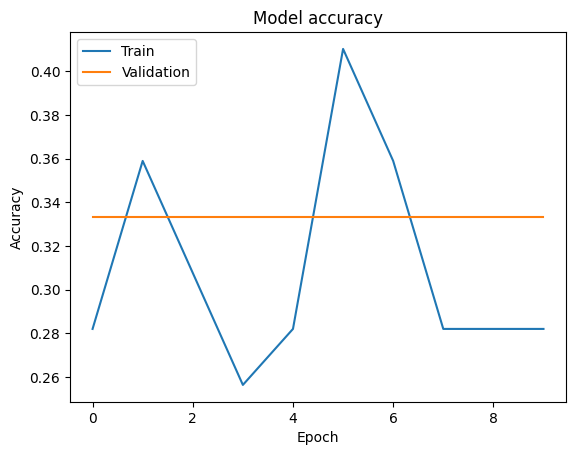

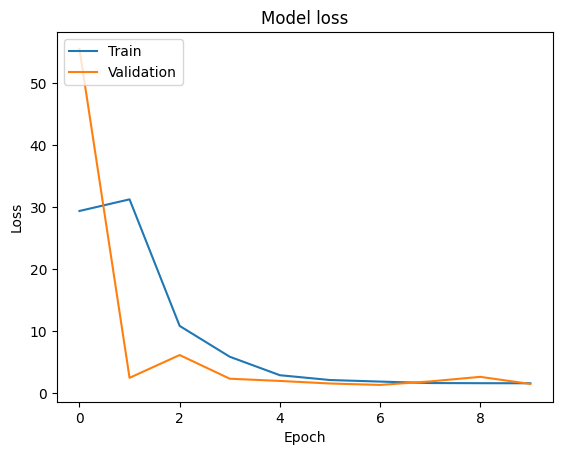

8/8 [==============================] - 15s 2s/step
predictions: [[0.10533199 0.13529156 0.7593764 ]
 [0.11610588 0.13864373 0.74525034]
 [0.12364167 0.13954574 0.73681253]
 [0.11596408 0.12718359 0.7568524 ]
 [0.11721787 0.13907036 0.7437118 ]
 [0.11691207 0.13879101 0.74429697]
 [0.1168866  0.13876106 0.74435234]
 [0.11611659 0.13863982 0.7452436 ]
 [0.12350253 0.14344853 0.7330489 ]
 [0.11682203 0.13874201 0.74443597]
 [0.11688804 0.1387615  0.7443505 ]
 [0.10533029 0.1352893  0.7593804 ]
 [0.12364275 0.13954458 0.7368127 ]
 [0.1203053  0.14173399 0.7379607 ]
 [0.11782793 0.13434662 0.74782544]
 [0.12367173 0.13954313 0.7367851 ]
 [0.12364658 0.13954367 0.73680973]
 [0.12342611 0.13948807 0.7370858 ]
 [0.11575791 0.1384285  0.74581355]
 [0.11687636 0.13875845 0.7443652 ]
 [0.10532986 0.13528726 0.7593829 ]
 [0.12049403 0.14186546 0.73764044]
 [0.11648912 0.13865025 0.7448606 ]
 [0.12364352 0.13954562 0.73681086]
 [0.12998295 0.14646566 0.72355145]
 [0.13148658 0.14715977 0.72135365]


In [20]:

# Hyperparameters
BATCH_SIZE = 5
EPOCHS = 3

# Define the directory containing your video frames
onevid = "../Data/train/bed/05630.mp4"
train_dir = Path('../Data/train/')
val_dir = Path('../Data/val/')
video_files = list(train_dir.glob('**/*.mp4'))
classes = set([p.parent.name for p in video_files])

# First, convert string labels to integers
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(list(classes))

# Then convert integer labels to one-hot vectors
one_hot_encoded_labels = to_categorical(integer_encoded)

hot_classes = dict(zip(list(classes), one_hot_encoded_labels))

content = json.load(open('../gloss_video_id.json', encoding = 'utf-8'))
X = []
y = []

cap = cv2.VideoCapture(onevid)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
ret, frame = cap.read()
cap.release()

early_stop = EarlyStopping(
    monitor='val_loss',  # Metric to monitor for improvement
    patience=300,          # Number of epochs to wait before stopping
    restore_best_weights=True  # Revert to the best model state
)

# Initialize the Hyperband tuner
tuner = Hyperband(
    build_model,
    objective='accuracy',
    max_epochs=10,
    factor=3,
    directory='my_dir2',
    project_name='inception_hyperband'
)

# Initialize frame generators
train_generator = VideoGenerator(input_dir = train_dir, batch_size=BATCH_SIZE, frame_count=frame_count, height=height, width=width, num_classes=len(classes))
val_generator = VideoGenerator(input_dir = val_dir, batch_size=BATCH_SIZE, frame_count=frame_count, height=height, width=width, num_classes=len(classes))

# Perform the search using the generators
tuner.search(train_generator, validation_data=val_generator, epochs=10, steps_per_epoch=len(train_generator), validation_steps=len(val_generator),callbacks=[early_stop])
#tuner.search(train_generator, validation_data=val_generator, epochs=10, steps_per_epoch=len(train_generator), validation_steps=len(val_generator))

base_model = InceptionV3(weights='imagenet', include_top=False, pooling='avg')
base_model.trainable = False

input_tensor = Input(shape=(frame_count, height, width, 3))
processed_frames = layers.TimeDistributed(base_model)(input_tensor)

x = layers.GRU(frame_count, return_sequences=True)(processed_frames)
x = layers.Flatten()(x)

x = layers.Dense(2048)(x)
x = layers.LeakyReLU(alpha=0.02)(x)

x = layers.Dense(1024)(x)
x = layers.ReLU()(x)

x = layers.Dense(768)(x)
x = layers.LeakyReLU(alpha=0.02)(x)

x = layers.Dense(384)(x)
x = layers.ReLU()(x)

outputs = layers.Dense(len(classes), activation='softmax')(x)

model = models.Model(inputs=input_tensor, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.000011753)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

steps_per_epoch = math.ceil((len(classes) * 13)/BATCH_SIZE)
val_steps_per_epoch = math.ceil((len(classes) * 1)/BATCH_SIZE)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    steps_per_epoch=steps_per_epoch,
    validation_steps=val_steps_per_epoch,
    epochs=10
)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

y_pred = model.predict(train_generator)
preds = find_prediction(y_pred)
print(preds)